## Working with Gridded Climate Data

The gridded data format is useful to compactly store large datsets, especially where variables are defined in multiple dimensions. 
One common example is climate data - global climate projections store a number of variables (temperature, relative humidity, precipitation) at a large number of grid cells (sometimes millions of grid cells), for every day. 
This quickly adds up to a huge dataset which wouldn't be practical to distribute or analyze. 
The gridded data format allows regular researchers to access the output of these global models. 

Today, we'll be working with a downscaled climate projection from CMIP6. I gathered a small file to demonstrate features of gridded data: just grid cells in the state of Massachusetts.  This file is accessed from [this link](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6), and here's the [paper](https://www.nature.com/articles/s41597-022-01393-4) describing the dataset. 

Many other datasets also use this format, including 
* [Historical weather](https://www.climatologylab.org/gridmet.html)
* [Satellite data](https://disc.gsfc.nasa.gov/datasets/GFEI_CH4_1/summary) 
* [Emissions monitoring](https://data.pnnl.gov/dataset/CEDS-4-21-21)
* [Fire risk factors](https://climate.ncsu.edu/fire/guide/gridded/) 


### Some projects I've used climate data for: 
* Developing temperature projections for Massachusetts 
<!-- 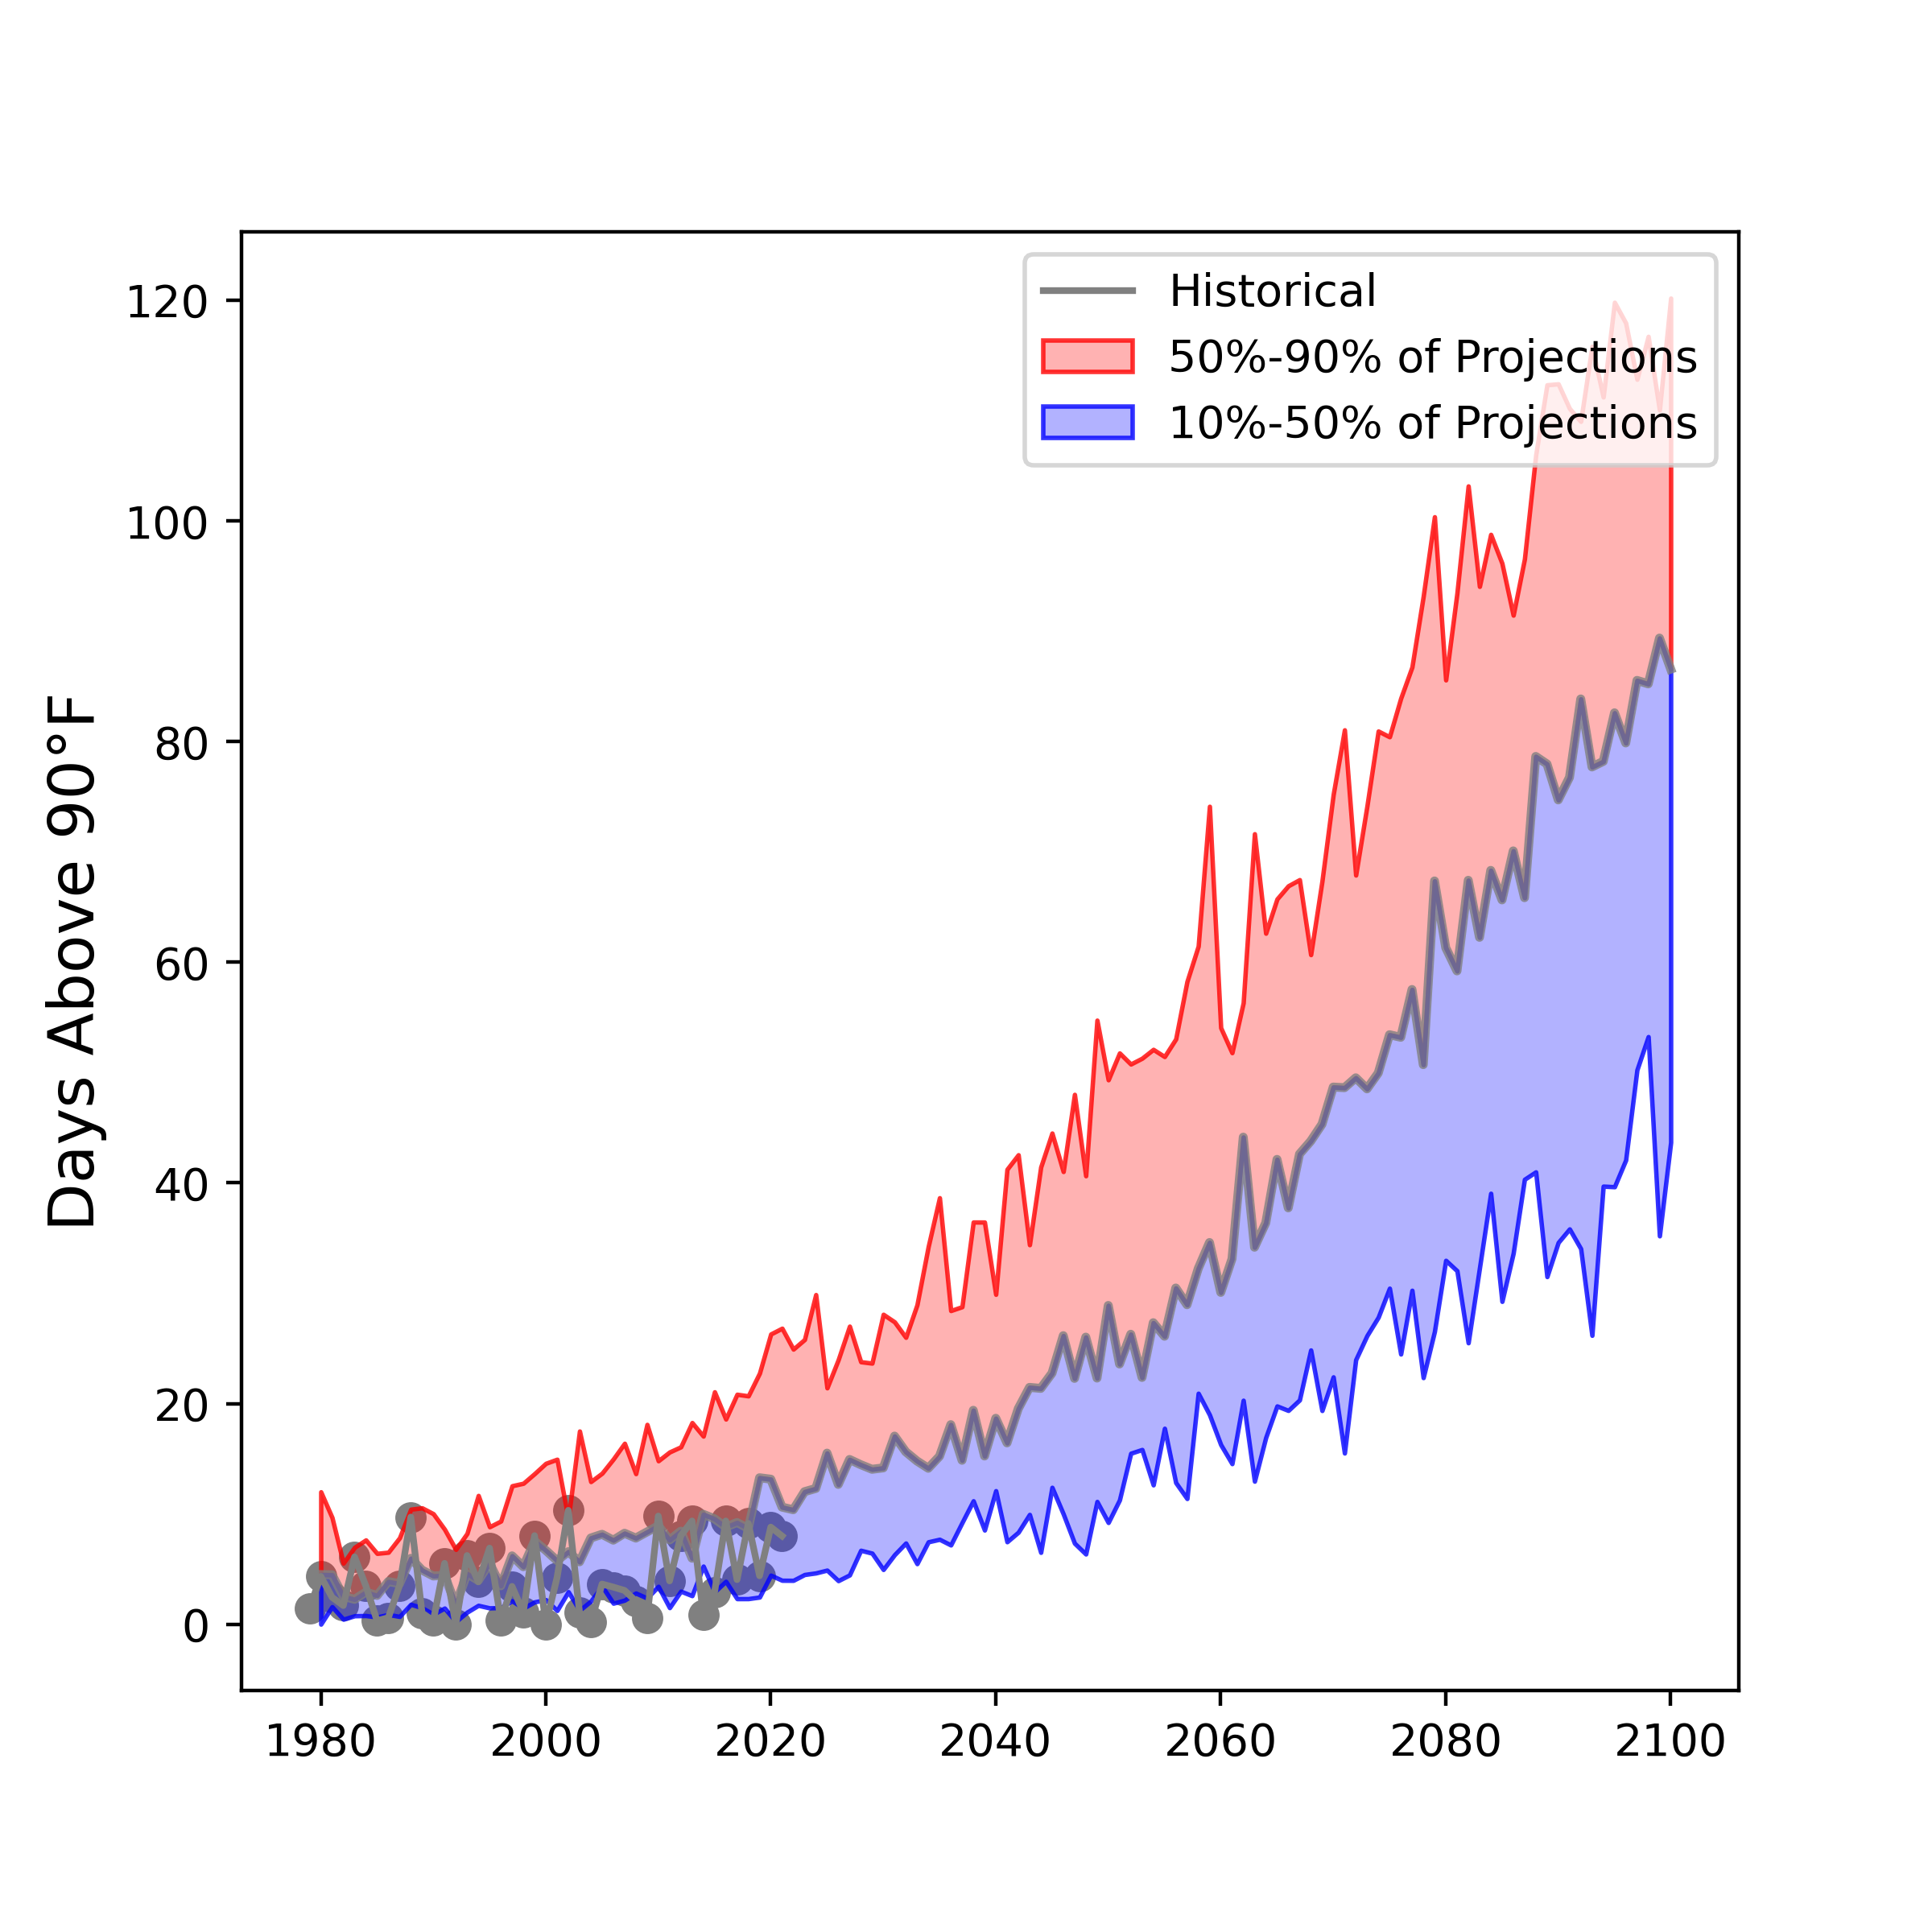 -->
<div align="left">
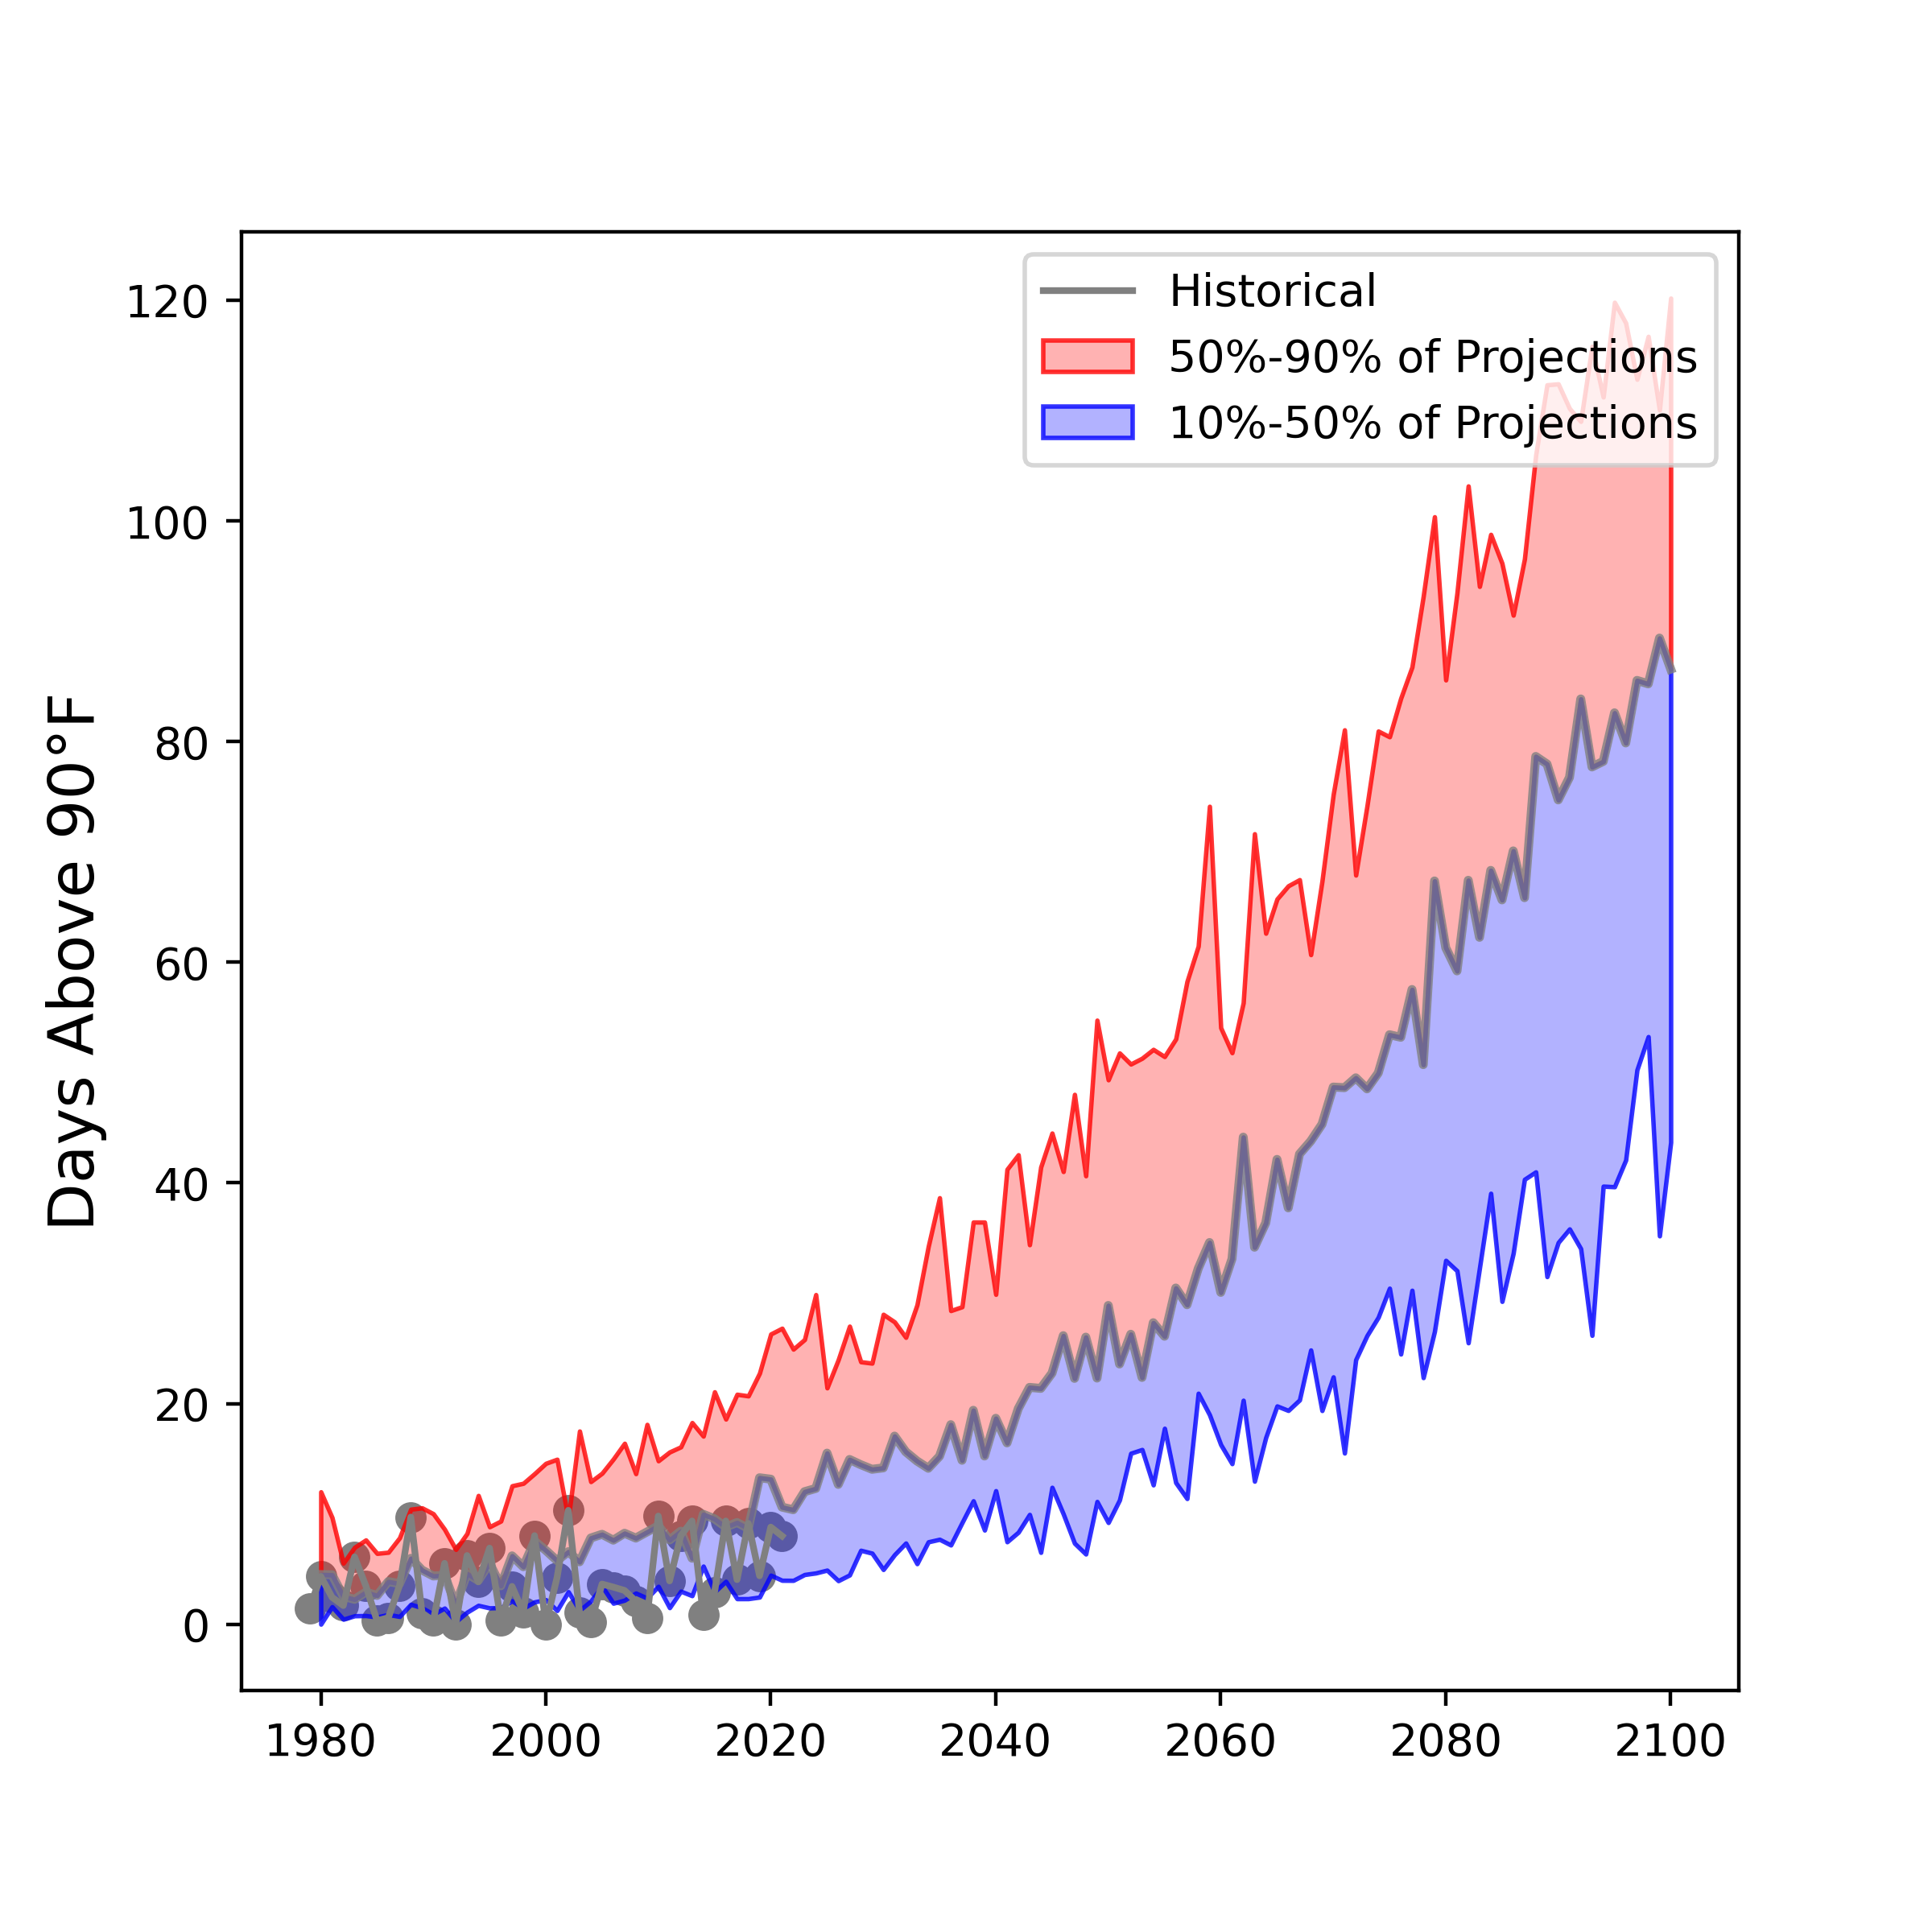
</div>


* Measuring role of extreme weather on agricultural yield 
<div align="left">
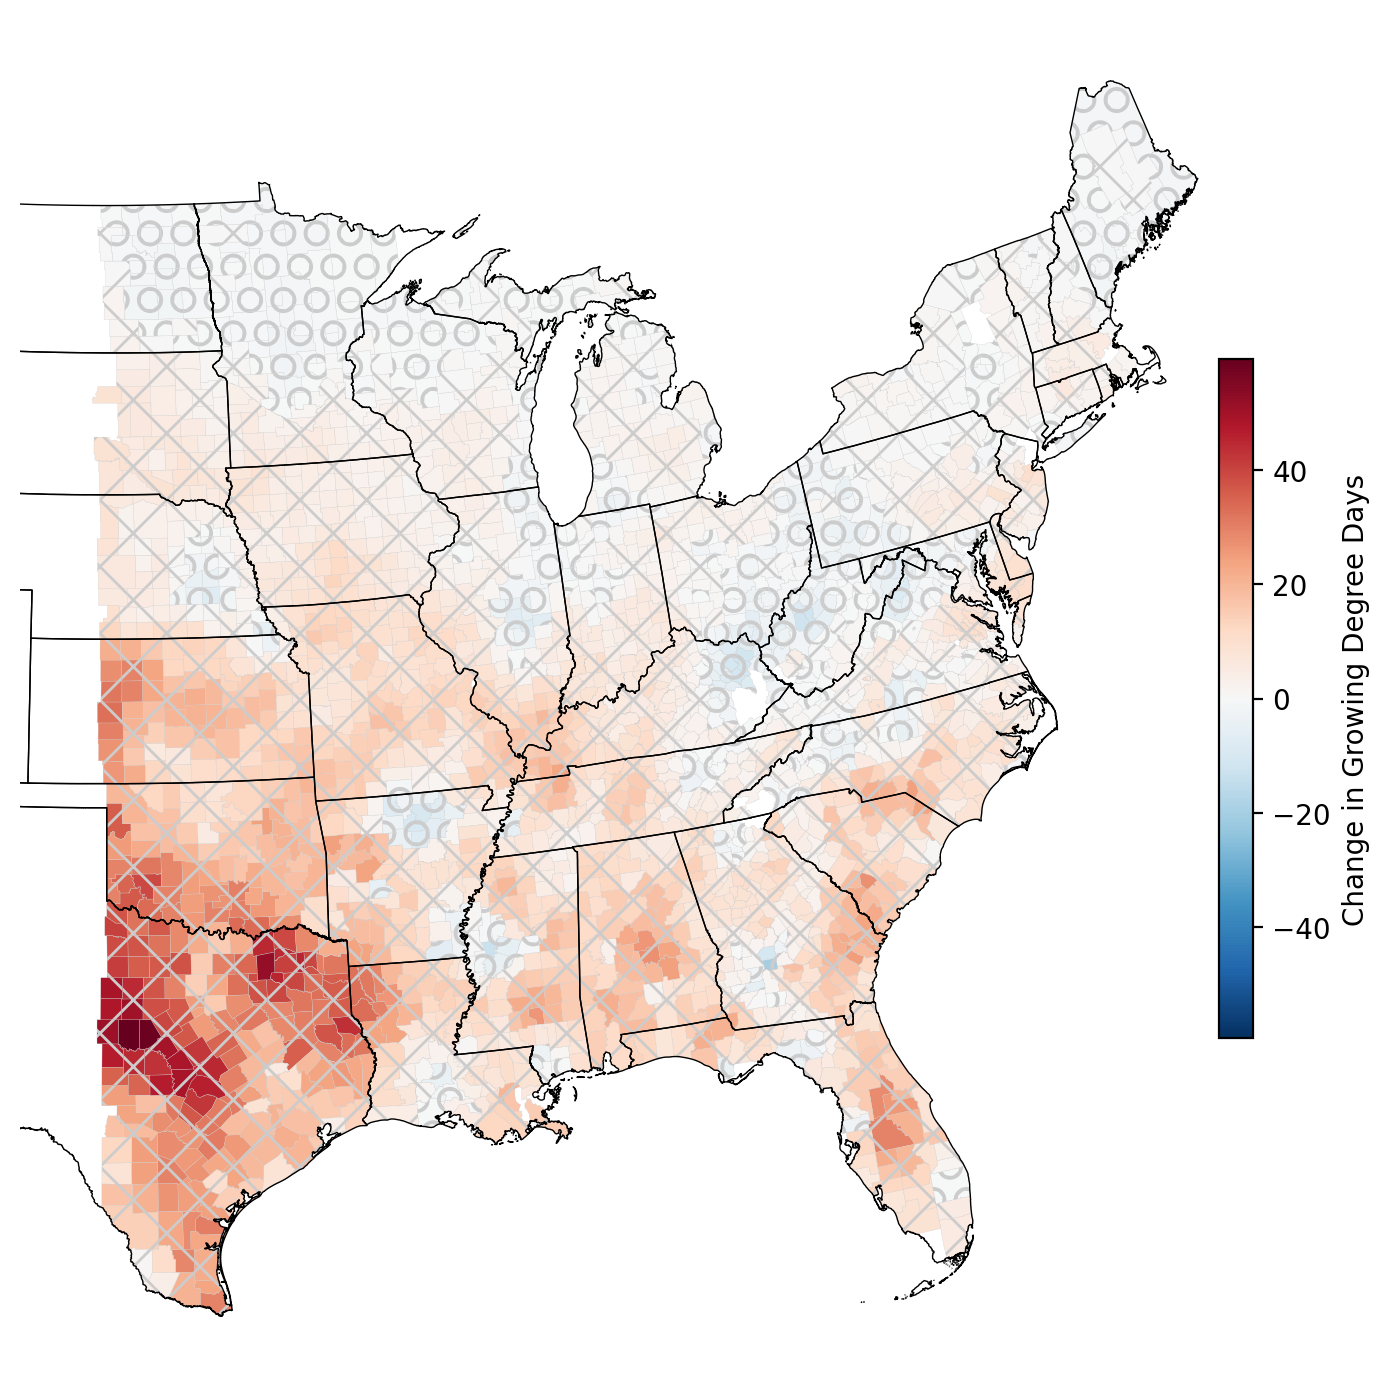
</div>
<!-- 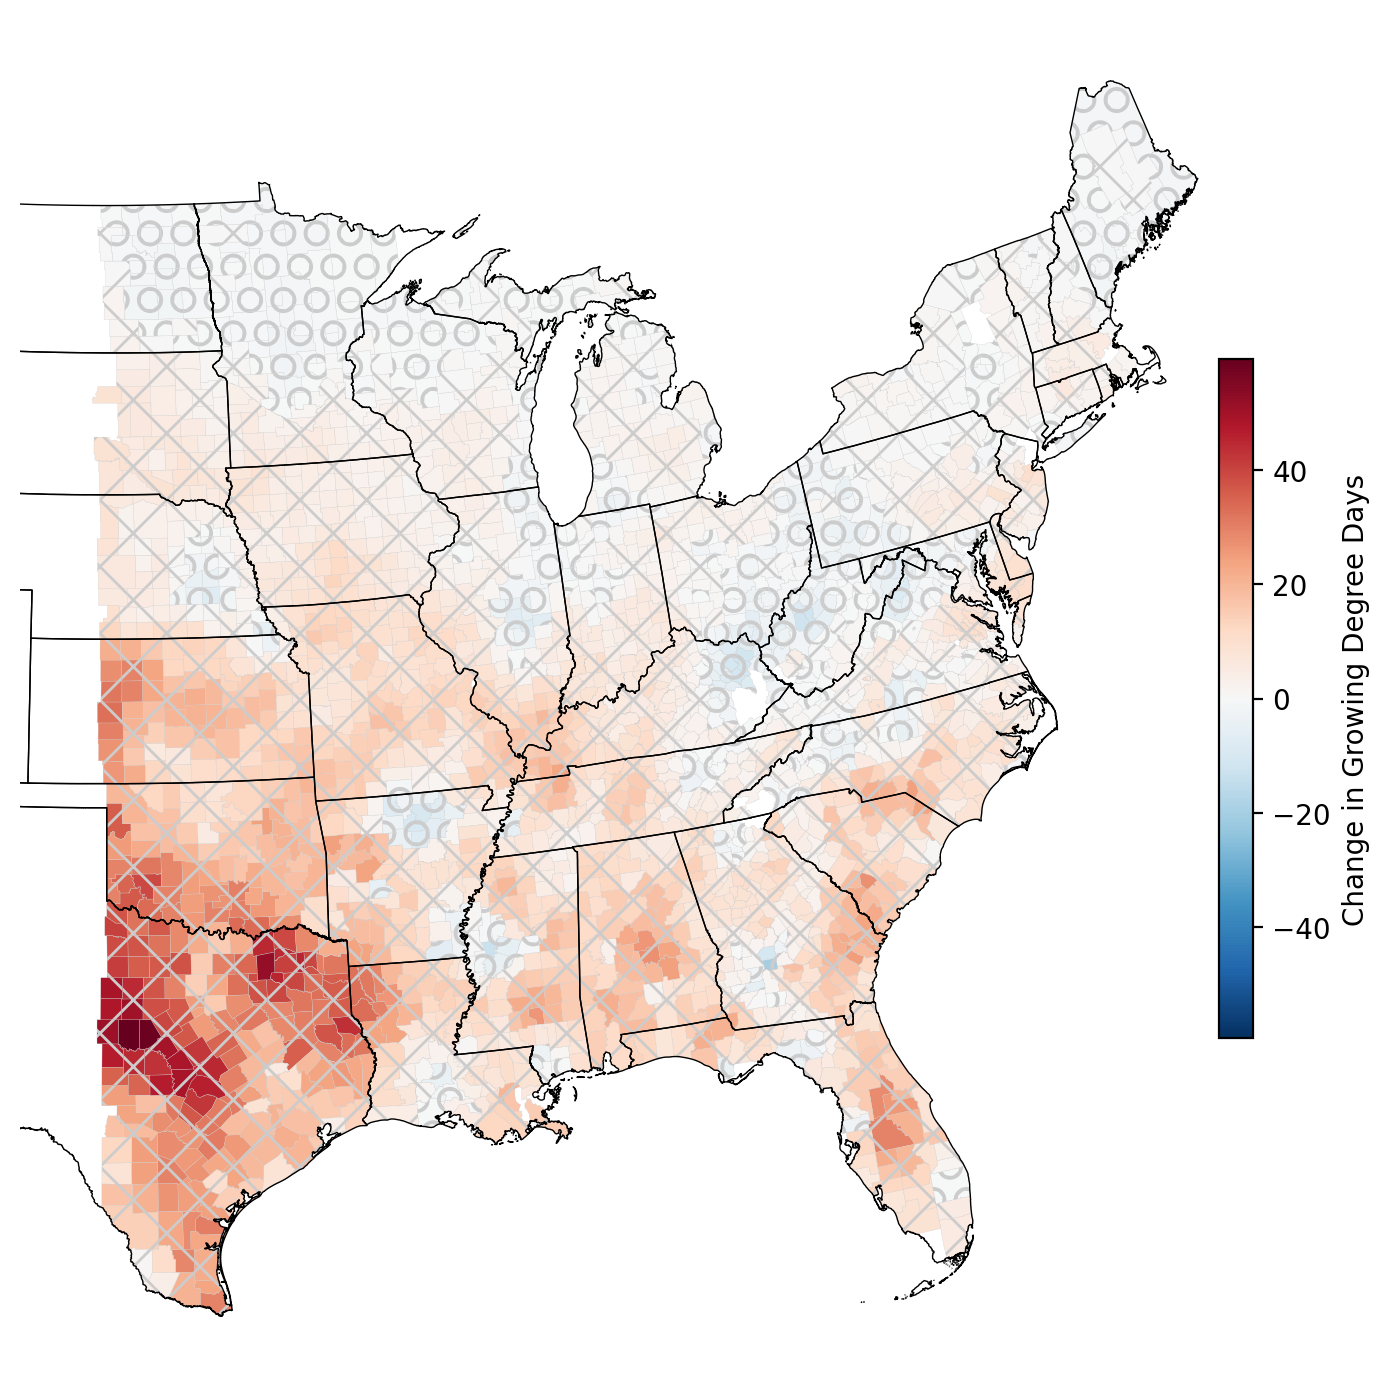 -->

### Reading a file 
We use the [NetCDF package](https://unidata.github.io/netcdf4-python/) in python. 

For R, there's an analogous package [here](https://cran.r-project.org/web/packages/ncdf4/index.html).

Files contain detailed metadata, and then a compact storage format of the data. The storage format uses dimensions (to define the data) and fields (to store the data; each field can be defined by any number of dimensions). In this case, the data contains the dimensions ``time(360), lat(8), lon(16)`` and the field ``tasmin``.

After opening the file (by declaring it as a `Dataset`), we can inspect the contents

In [1]:
import netCDF4 as nc
import numpy as np
nc_file = 'MA_ssp585_UKESM1-0-LL_tasmin_2100.nc'
ds = nc.Dataset(nc_file, 'r')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    activity: NEX-GDDP-CMIP6
    contact: Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org
    Conventions: CF-1.7
    creation_date: 2021-10-04T20:27:22.364780+00:00
    frequency: day
    institution: NASA Earth Exchange, NASA Ames Research Center, Moffett Field, CA 94035
    variant_label: r1i1p1f2
    product: output
    realm: atmos
    source: BCSD
    scenario: ssp585
    references: BCSD method: Thrasher et al., 2012, Hydrol. Earth Syst. Sci.,16, 3309-3314. Ref period obs: latest version of the Princeton Global Meteorological Forcings (http://hydrology.princeton.edu/data.php), based on Sheffield et al., 2006, J. Climate, 19 (13), 3088-3111.
    version: 1.0
    tracking_id: 431c39eb-5393-4b1c-86d3-0745a28e114e
    title: UKESM1-0-LL, r1i1p1f2, ssp585, global downscaled CMIP6 climate projection data
    resolution_id: 0.25 degree
    hist

In [2]:
# To display information about a particular variable, access it via the dictionary
ds['tasmin'][:][0,0,0]

276.5293

In [3]:
# Access the contents of the file as a numpy object 
ds['lon'][:]

masked_array(data=[286.375, 286.625, 286.875, 287.125, 287.375, 287.625,
                   287.875, 288.125, 288.375, 288.625, 288.875, 289.125,
                   289.375, 289.625, 289.875, 290.125],
             mask=False,
       fill_value=1e+20)

In [4]:
print(ds['tasmin'])
ds['tasmin'][:].shape

<class 'netCDF4._netCDF4.Variable'>
float32 tasmin(time, lat, lon)
    _FillValue: 1e+20
    standard_name: air_temperature
    long_name: Daily Minimum Near-Surface Air Temperature
    units: K
    comment: minimum near-surface (usually, 2 meter) air temperature (add cell_method attribute 'time: min')
    cell_methods: area: mean time: minimum
    cell_measures: area: areacella
    _ChunkSizes: [   1  600 1440]
    coordinates: time lat lon 
unlimited dimensions: time
current shape = (360, 8, 16)
filling on


(360, 8, 16)

### Editing files
NetCDF files are designed to store data, so it can be a bit tricky to edit files. My method is usually to create a new file. 

In this example, let's make two changes to the current dataset:
* Convert Kelvin temperatures to Fahrenheit 
* Convert longitude to negative values
* Extend the 360 day calendar year to 365 days (this is actually a standard processing step for climate datasets - [see here](https://loca.ucsd.edu/loca-calendar/) for more detail)

In [5]:
# First, let's see how to generate a file
outfile = 'modified_dataset.nc'
modified = nc.Dataset(outfile, 'w', clobber=True)
modified

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 

In [6]:
# Let's add some dimensions - latitude, longitude, and date from above 
# When creating dimension, need to specify a size (or None)
modified.createDimension("lat", len(ds['lat']))
modified.createDimension("lon", len(ds['lon']))
modified.createDimension("day", None)
modified

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(8), lon(16), day(0)
    variables(dimensions): 
    groups: 

In [7]:
# Now, let's add variables 
# When creating variables, you need to specify:
# 1. the data type  
# 2. the dimensions associated with the variable
# Format: variable = model.createVariable(name, dtype, (dimensions))
lat = modified.createVariable("lat", "f8", ("lat",)) 
lon = modified.createVariable("lon", "f8", ("lon",)) 
day = modified.createVariable("day", "i8", ("day",)) 
tmin = modified.createVariable("tmin", "f8", ("day", "lat", "lon"))
modified

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(8), lon(16), day(0)
    variables(dimensions): float64 lat(lat), float64 lon(lon), int64 day(day), float64 tmin(day, lat, lon)
    groups: 

In [8]:
# Setting contents of the file: let's start with dimensions
# Set the contents (the [:]) of the new file 
# Can be any object that meets the shape requirements 
lat[:] = ds['lat'][:]
lon[:] = ds['lon'][:] - 360
import numpy as np
day[:] = np.arange(365)
# modified['day'][:][0:4]

In [9]:
modified['day'][:][0:5]

masked_array(data=[0, 1, 2, 3, 4],
             mask=False,
       fill_value=999999)

In [10]:
# Now to modify the temperature values: 
# first let's load the values and convert them to Fahrenheit 
temp = ds['tasmin'][:]
print("Original shape", temp.shape)
print("Sample value in K:", temp[0,0,0])
def kelvinToFahrenheit(kelvin):
    return kelvin * 1.8 - 459.67
temp = kelvinToFahrenheit(temp)
print("Sample value in F:", temp[0,0,0])

# Now to interpolate missing values 
# this procedure is from LOCA's guide 
time_length = len(ds['time'])
# First, randomly select elements to interpolate new values 
year = 2100
if time_length < 365:
    to_interpolate = 365 - time_length
    new_elements = np.random.randint(0, high=time_length / to_interpolate, size=to_interpolate, dtype=int)
    new_elements = new_elements + [x * time_length / to_interpolate for x in range(to_interpolate)]
    new_elements = list(new_elements.astype(int))
else:
    new_elements = []
if (time_length < 366) and (year % 4 == 0) and (year != 2100):
    new_elements.append(59)
print("Adding these elements:",new_elements)


Original shape (360, 8, 16)
Sample value in K: 276.5293
Sample value in F: 38.082703
Adding these elements: [44, 75, 162, 261, 346]


In [11]:
# Now insert interpolated values into the temp matrix  
# Note: inserting column of average values, into the 0th axis of the new data 
update = temp.copy()
for element in reversed(new_elements):
    to_average = [element, element -1 if element > 0 else element + 1]
#     print(to_average)
#     print(update[to_average, 0, 0])
    new_values = np.mean(update[to_average,:,:], axis=0)
    print(new_values.shape)
#     print(new_values[0,0])
    update = np.insert(update, element, new_values, axis=0)
print("Shape after adding new entries:", update.shape) # Should now have 365 values
print("A sample to see if we're interpolating:", update[element-1:element+2, 0, 0]) # Should be interpolated between low and high values. 
print("A sample to see if we're interpolating:", update[element-1:element+2, 0, 13]) # Should be interpolated between low and high values. 

(8, 16)
(8, 16)
(8, 16)
(8, 16)
(8, 16)
Shape after adding new entries: (365, 8, 16)
A sample to see if we're interpolating: [44.120697 42.864426 41.608154]
A sample to see if we're interpolating: [1.e+20 1.e+20 1.e+20]


#### Masked values
One common feature of these data are masked values. 
In datasets of land temperatures, it's common to mask values from water bodies. 
Values might also be masked due to data quality issues. 

In the example above, `lat[0]` and `lon[13]` is masked - you can see this because instead of a temperature, we get the masked value: `1.e+20`.
If you look at this location in google maps, you might see why. 

To work with a masked array, it's important to not accidentally read masked values, and to properly preserve their order. In the next few blocks we'll show how to:
* Read masked state of a variable
* Preserve masked state while updating data

In [12]:
print(lat[:][0], "N,", np.abs(lon[:][13]), "W")

41.125 N, 70.375 W


In [13]:
temp_mask = ds['tasmin'][:].mask
temp_mask.shape

(360, 8, 16)

In [14]:
# Interpolating with masks: I use np.any. Could also use "all" and interpolate only on unmasked values
is_masked = np.any(temp_mask[to_average, :, :], axis=0)
is_masked.shape

(8, 16)

In [15]:
update = temp.copy()
update_mask = temp_mask.copy()
for element in reversed(new_elements):
    to_average = [element ,
                  element -1 if element > 0 else element + 1]
#     print(to_average)
#     print(update[to_average, 0, 0])
    new_values = np.mean(update[to_average,:,:], axis=0)
    is_masked = np.any(update_mask[to_average, :, :], axis=0)
#     print(new_values[0,0])
    update = np.insert(update, element, new_values, axis=0)
    update_mask = np.insert(update_mask, element, is_masked, axis=0)
update.mask = update_mask
print("Shape after adding new entries:", update.shape) # Should now have 365 values
print("A sample to see if we're interpolating:", update[element-1:element+2, 0, 0]) # Should be interpolated between low and high values. 
print("A sample to see if we're interpolating:", update[element-1:element+2, 0, 13]) # Should be interpolated between low and high values. 

Shape after adding new entries: (365, 8, 16)
A sample to see if we're interpolating: [44.120697021484375 42.86442565917969 41.608154296875]
A sample to see if we're interpolating: [-- -- --]


In [16]:
# Now, we can store the updated temperature field into the NC database
modified['tmin'][:] = update

In [17]:
# Final step with database: close file
modified.close()
ds.close()

## Merging Gridded Dataset with Shape File
While gridded datasets are a very compact form, they're quite challenging to work with. 
It is often desirable to merge these observations with records from a shape file. 
In this section, we'll show how to take gridded observations and make a county-level dataset. 

Each longitude/latitude pair in the gridded dataset defines the center of a "grid cell", with area defined by the grid width. 
This lets us translate the gridded dataset into its own set of shape files, which we can then use to merge with other objects. 

Here, we'll go through the following steps: 
* Plot the geographic extent of the gridded database 
* Find the weather in a sample county (Middlesex County) 
* Plot the daily weather predictions in all counties in Massachusetts

In [18]:
# First, let's load the modified dataset 
ds = nc.Dataset('modified_dataset.nc', 'r')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(8), lon(16), day(365)
    variables(dimensions): float64 lat(lat), float64 lon(lon), int64 day(day), float64 tmin(day, lat, lon)
    groups: 

<AxesSubplot: >

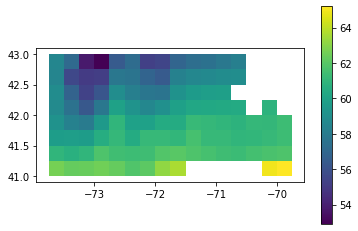

In [19]:
# let's visualize the gridded data. 
# Just seeing where the lat/lon points are on the map
# Plotting average annual temperature per grid point (omitting masked values)
import geopandas as gpd
from shapely.geometry import MultiPoint
import numpy as np
x_orig, y_orig = np.meshgrid(ds['lat'], ds['lon'], indexing='ij')
orig_shape = x_orig.shape
x, y = x_orig.flatten(), y_orig.flatten()
resolution = 0.25
width = resolution / 2 
s = gpd.GeoSeries([MultiPoint([[_y - width, _x - width], [_y + width, _x + width]]).envelope \
                   for _x, _y in zip(x,y)])
gdf = gpd.GeoDataFrame(geometry=s)
gdf['avg_temp'] = np.mean(ds['tmin'][:], axis=0).flatten()
gdf.plot(column='avg_temp', legend=True)

<AxesSubplot: >

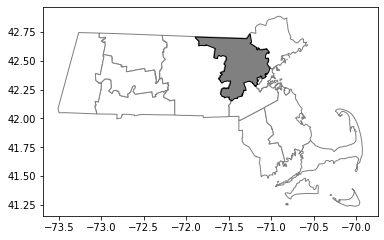

In [20]:
# Trying to merge this with Massachusetts counties; starting with Middlesex as a sample county 
# We can load the whole file, and use this later. 
counties = gpd.read_file('cb_2018_us_county_500k')
counties = counties[counties.STATEFP == '25']
counties['GEOID'] = counties['GEOID'].astype(int)
counties = counties.to_crs("EPSG:4326")
ax = counties.plot(color='white',edgecolor='grey')
county = counties[counties.GEOID == 25017].iloc[0]
counties[counties.GEOID == 25017].plot(ax=ax, color='grey', linewidth=1.0, edgecolor='k')

,geometry,intersect_area
72,"POLYGON ((-71.50000 42.25000, -71.50000 42.179...",0.005620
73,"POLYGON ((-71.50000 42.25000, -71.30335 42.250...",0.011320
88,"MULTIPOLYGON (((-71.50000 42.25000, -71.59033 ...",0.014883
89,"POLYGON ((-71.50000 42.25000, -71.50000 42.284...",0.057212
90,"POLYGON ((-71.25000 42.50000, -71.04308 42.500...",0.033185


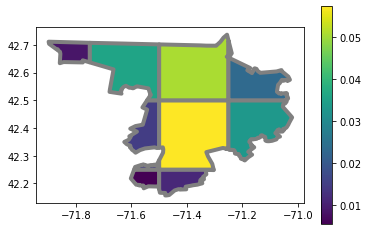

In [21]:
# With an individual county, we can take an intersection with the grid cells 
# Here, I'm plotting the area of the intersection
# We'll use the area of the intersection to merge the temperature from grid cells 
intersection = s.intersection(county.geometry)
gdf = gpd.GeoDataFrame(geometry=intersection)
gdf['intersect_area'] = gdf.area
gdf[gdf.area > 0].plot(column='intersect_area', linewidth=4.0, edgecolor='grey', legend=True)
gdf[gdf.area > 0].head()

In [22]:
# Getting average values per county - note the treatment of masked values 
# Key here: weighted average of values per county.
# Can use a tool like np.average; I find np.tensordot is considerably faster 
# Tensordot does multiplication of each element in an array. 
overlap = s.intersection(county.geometry).area.values.reshape(orig_shape)
mask = ds['tmin'][:].mask
overlap = np.multiply(overlap, ~mask[0,...])
overlap
overlap = overlap.flatten()
flat_vals = ds['tmin'][...].reshape((ds['tmin'].shape[0], -1))
means = np.tensordot(flat_vals, overlap, axes=1) / np.sum(overlap)
means.shape

(365,)

In [23]:
# I find it convenient to work with pandas dataframes - converting these files: 
import datetime
import pandas as pd
frame = pd.DataFrame(means, columns=['tmin'])
frame['date'] = [datetime.date(2100,1,1) + \
                        datetime.timedelta(int(d)) for d in range(len(means))]
frame['fips'] = county.GEOID
frame.head()

,tmin,date,fips
0,36.447282,2100-01-01,25017
1,35.458581,2100-01-02,25017
2,43.649377,2100-01-03,25017
3,39.876094,2100-01-04,25017
4,38.692978,2100-01-05,25017


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot: >

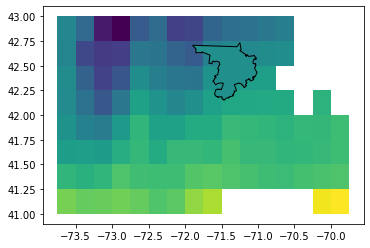

In [24]:
# To show this averaged value in context: 
gdf = gpd.GeoDataFrame(geometry=s)
gdf['avg_temp'] = np.mean(ds['tmin'][:], axis=0).flatten()
vmin = np.min(gdf['avg_temp'])
vmax = np.max(gdf['avg_temp'])
ax = gdf.plot(column='avg_temp', vmin=vmin, vmax=vmax)
to_plot = counties[counties.GEOID == 25017]
to_plot['avg_temp'] = np.mean(frame['tmin'])
to_plot.plot(column='avg_temp',ax=ax, linewidth=1.0, edgecolor='k', vmin=vmin, vmax=vmax)

In [25]:
# Now let's generate this dataset for all counties! 
overall_df = None
for i, county in counties.iterrows(): 
    overlap = s.intersection(county.geometry).area.values.reshape(orig_shape)
    mask = ds['tmin'][:].mask
    overlap = np.multiply(overlap, ~mask[0,...])
    overlap = overlap.flatten()
    flat_vals = ds['tmin'][...].reshape((ds['tmin'].shape[0], -1))
    means = np.tensordot(flat_vals, overlap, axes=1) / np.sum(overlap)
    frame = pd.DataFrame(means, columns=['tmin'])
    frame['day_of_year'] = np.arange(len(means))
    frame['date'] = [datetime.date(2100,1,1) + \
                            datetime.timedelta(int(d)) for d in range(len(means))]
    frame['fips'] = county.GEOID
    frame['name'] = county.NAME
    overall_df = pd.concat([overall_df, frame])
overall_df.head()

,tmin,day_of_year,date,fips,name
0,39.314122,0,2100-01-01,25001,Barnstable
1,37.346305,1,2100-01-02,25001,Barnstable
2,41.275888,2,2100-01-03,25001,Barnstable
3,40.663646,3,2100-01-04,25001,Barnstable
4,45.111204,4,2100-01-05,25001,Barnstable


In [26]:
# Remember to close the dataset
ds.close()

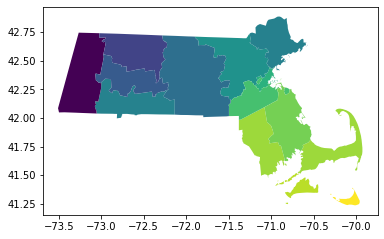

In [27]:
# Now let's visualize average temperatures! 
summary = overall_df.groupby('fips').mean()
merged = counties.merge(summary, left_on='GEOID', right_index=True)
merged.plot(column='tmin');

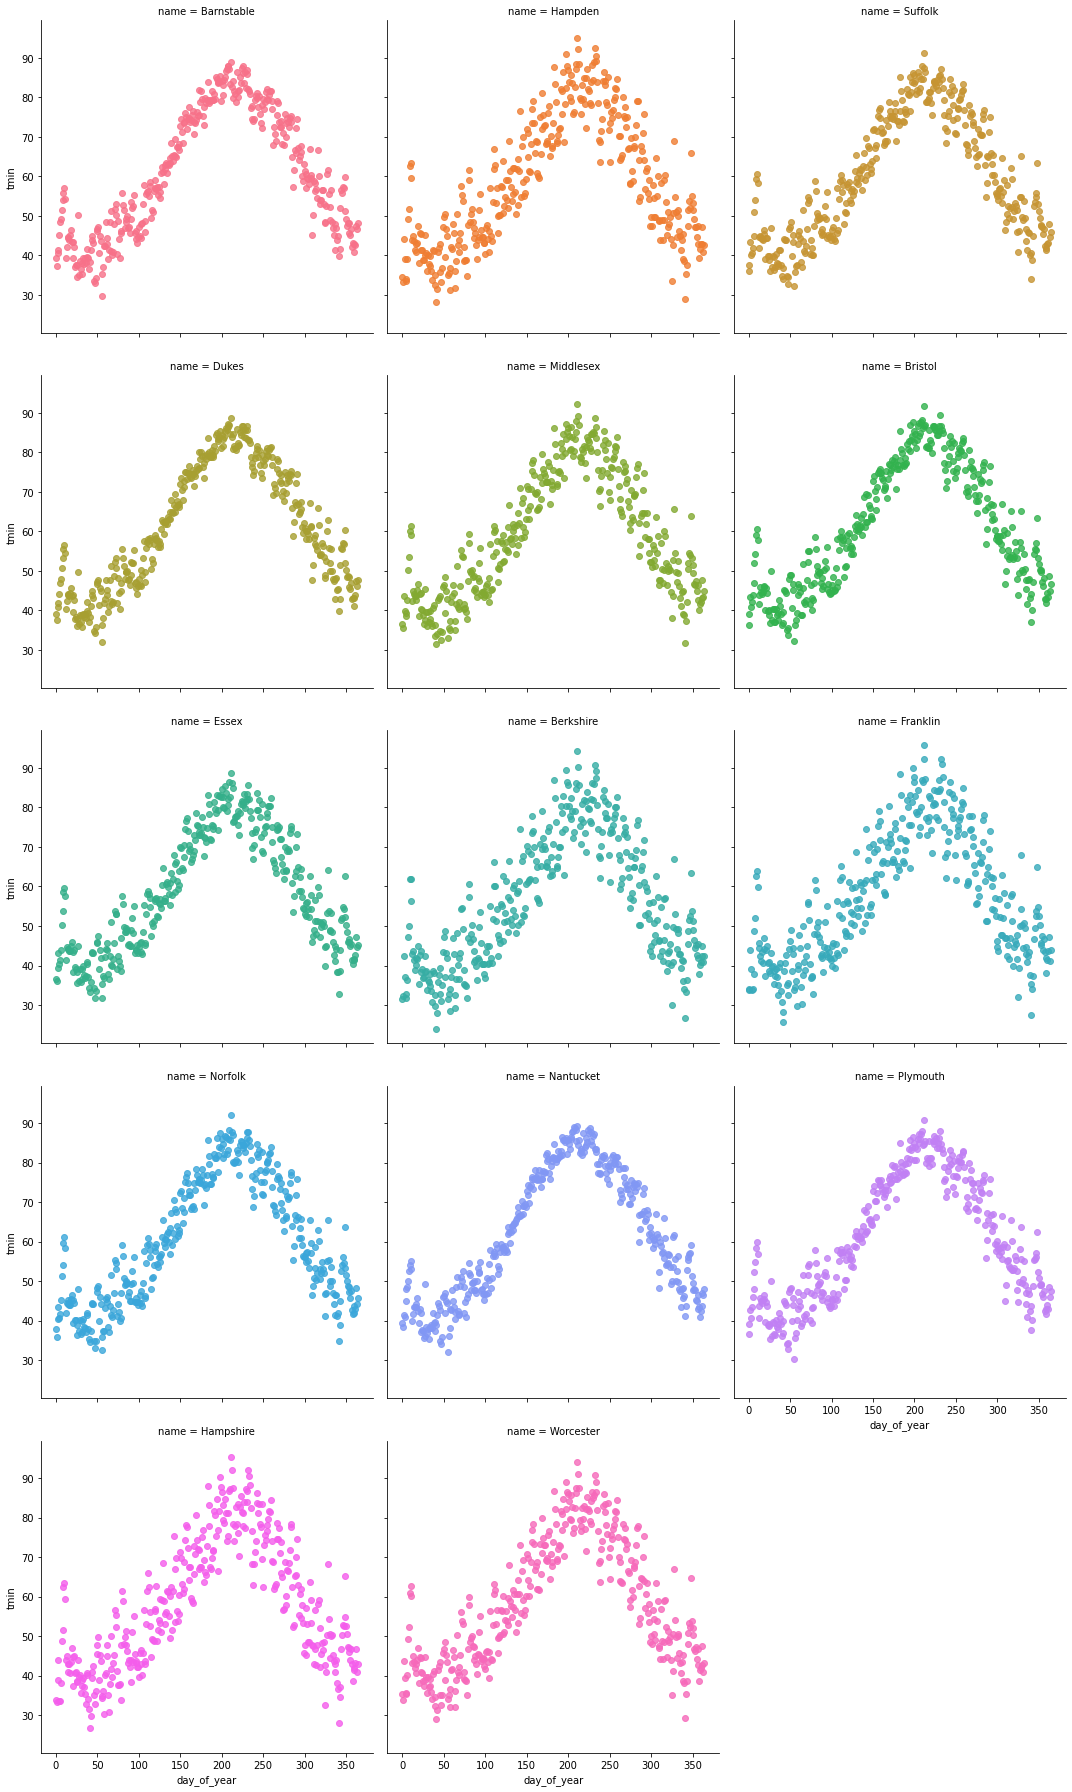

In [28]:
# An alternate visualization - let's look at daily temperature in each county! 
import seaborn as sns
sns.lmplot(x='day_of_year', y ='tmin', hue='name', col='name', col_wrap=3,
           data=overall_df, fit_reg=False)